<a href="https://colab.research.google.com/github/MatteoGuglielmi-tech/Polarity-and-Subjectivity-Detection/blob/main/src/MyModel/BERT_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bert-Model


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


### Steps to import python files in Collaboratory
- go to Google Drive where the Jupyter Notebook containing the desired functions to import is
- download it with the .py extension
- run the following cell to put it in the content space

In this particular case we would need to import as a module the NTN file, containing the Neural Tensor Network implementation

In [2]:
import pandas as pd 
import numpy as np 
import re

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import gc
from typing import Tuple, List
import torch.optim as opt

In [3]:
def load_embeds(folder: str, kind:str)-> np.ndarray:
    output = np.load(root+f"BERT/{folder}/bert_emb_{kind}_100.npy")
    for i in range(1,20):
        tmp = np.load(root+f"BERT/{folder}/bert_emb_{kind}_{(i+1)*100}.npy")
        print(f"iteration {i}\n")
        print(f"len tmp {len(tmp)}\n")
        output = np.concatenate((output,tmp))
        print(f"len {kind}_embs {len(output)}\n")
        gc.collect()
    return output

In [4]:
root = '/content/gdrive/MyDrive/Colab Notebooks/Polarity-Subjectivity-Detection/'

In [5]:
pol_embs = load_embeds(folder='Polarity-Embeddings-Truncated', kind='pol')

iteration 1

len tmp 100

len pol_embs 200

iteration 2

len tmp 100

len pol_embs 300

iteration 3

len tmp 100

len pol_embs 400

iteration 4

len tmp 100

len pol_embs 500

iteration 5

len tmp 100

len pol_embs 600

iteration 6

len tmp 100

len pol_embs 700

iteration 7

len tmp 100

len pol_embs 800

iteration 8

len tmp 100

len pol_embs 900

iteration 9

len tmp 100

len pol_embs 1000

iteration 10

len tmp 100

len pol_embs 1100

iteration 11

len tmp 100

len pol_embs 1200

iteration 12

len tmp 100

len pol_embs 1300

iteration 13

len tmp 100

len pol_embs 1400

iteration 14

len tmp 100

len pol_embs 1500

iteration 15

len tmp 100

len pol_embs 1600

iteration 16

len tmp 100

len pol_embs 1700

iteration 17

len tmp 100

len pol_embs 1800

iteration 18

len tmp 100

len pol_embs 1900

iteration 19

len tmp 100

len pol_embs 2000



In [6]:
subj_embs = load_embeds(folder='Subjectivity-Embeddings-Truncated', kind='subj')

iteration 1

len tmp 100

len subj_embs 200

iteration 2

len tmp 100

len subj_embs 300

iteration 3

len tmp 100

len subj_embs 400

iteration 4

len tmp 100

len subj_embs 500

iteration 5

len tmp 100

len subj_embs 600

iteration 6

len tmp 100

len subj_embs 700

iteration 7

len tmp 100

len subj_embs 800

iteration 8

len tmp 100

len subj_embs 900

iteration 9

len tmp 100

len subj_embs 1000

iteration 10

len tmp 100

len subj_embs 1100

iteration 11

len tmp 100

len subj_embs 1200

iteration 12

len tmp 100

len subj_embs 1300

iteration 13

len tmp 100

len subj_embs 1400

iteration 14

len tmp 100

len subj_embs 1500

iteration 15

len tmp 100

len subj_embs 1600

iteration 16

len tmp 100

len subj_embs 1700

iteration 17

len tmp 100

len subj_embs 1800

iteration 18

len tmp 100

len subj_embs 1900

iteration 19

len tmp 100

len subj_embs 2000



In [7]:
print(len(subj_embs))

2000


In [8]:
print(pol_embs[0].shape)
print(pol_embs[1999].shape)

(45, 768)
(45, 768)


In [9]:
print(subj_embs[0].shape)
print(subj_embs[1999].shape)

(45, 768)
(45, 768)


In [10]:
gc.collect()

22

In [11]:
print(len(pol_embs))
print(type(pol_embs))

2000
<class 'numpy.ndarray'>


In [12]:
print(len(subj_embs))
print(type(subj_embs))

2000
<class 'numpy.ndarray'>


In [172]:
gc.collect()

7757

## Train/Test split
Preparing the data to be fed to the model

In [14]:
pol_labels = [1 if idx<1000 else 0 for idx in range(2000)]

In [15]:
pos = pol_labels[:1000]
neg = pol_labels[1000:]

In [16]:
len(pos)

1000

In [17]:
import torch
inp = torch.arange(1,16).reshape(5,3)
label = torch.randint(1,3,size=(5,))
print(inp)
print(label)

tensor([[ 1,  2,  3],
        [ 4,  5,  6],
        [ 7,  8,  9],
        [10, 11, 12],
        [13, 14, 15]])
tensor([2, 1, 2, 1, 2])


In [18]:
from torch.utils.data import TensorDataset as td

ds = td(inp, label)
for inp, label in ds:
    print('{}:{}'.format(inp, label))

tensor([1, 2, 3]):2
tensor([4, 5, 6]):1
tensor([7, 8, 9]):2
tensor([10, 11, 12]):1
tensor([13, 14, 15]):2


In [19]:
next(iter(ds))

(tensor([1, 2, 3]), tensor(2))

In [20]:
len(neg)

1000

In [21]:
subj_labels = [1 if idx<1000 else 0 for idx in range(2000)]

In [22]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler
from torch.utils.data import TensorDataset as td


def get_data(pol_embs: List[np.array], subj_embs: List[np.array], pol_labels: List[np.array], 
             subj_labels: List[np.array], batch_size: int=64, random_state=42, 
             test_split=0.2) -> Tuple[torch.utils.data.DataLoader]:

    pol_train, pol_test, pol_labels_train, pol_labels_test = train_test_split(pol_embs, 
                                                                              pol_labels,
                                                                              test_size=test_split, 
                                                                              random_state=random_state)
    
    subj_train, subj_test, subj_labels_train, subj_labels_test = train_test_split(subj_embs, 
                                                                                  subj_labels,
                                                                                  test_size=test_split,
                                                                                  random_state=random_state)

    pol_train = td(torch.Tensor(pol_train), torch.Tensor(pol_labels_train))
    pol_test = td(torch.Tensor(pol_test), torch.Tensor(pol_labels_test))
    subj_train = td(torch.Tensor(subj_train), torch.Tensor(subj_labels_train))
    subj_test = td(torch.Tensor(subj_test), torch.Tensor(subj_labels_test))

    
    pol_train_loader = DataLoader(dataset=pol_train, 
                                  batch_size=batch_size,
                                  sampler=RandomSampler(pol_train), 
                                  shuffle=False)
    
    pol_test_loader = DataLoader(dataset=pol_test, 
                                 batch_size=batch_size,
                                 sampler=RandomSampler(pol_test), 
                                 shuffle=False)

    subj_train_loader = DataLoader(dataset=subj_train, 
                                   batch_size=batch_size,
                                   sampler=RandomSampler(subj_train),
                                   shuffle=False)
    
    subj_test_loader = DataLoader(dataset=subj_test,
                                  batch_size=batch_size,
                                  sampler=RandomSampler(subj_test), 
                                  shuffle=False)
    
    return pol_train_loader, pol_test_loader, subj_train_loader, subj_test_loader

In [23]:
#pol_train = get_data(pol_embs=pol_embs, 
#                     subj_embs=subj_embs, 
#                     pol_labels=pol_labels,
#                     subj_labels=subj_labels)

In [24]:
#for inp, label in pol_train:
#    print('{}:{}'.format(inp, label))

In [25]:
pol_train, pol_val, subj_train, subj_val = get_data(pol_embs=pol_embs, 
                                                    subj_embs=subj_embs,
                                                    pol_labels=pol_labels,
                                                    subj_labels=subj_labels,
                                                    batch_size=128)

In [26]:
for idx, (datum, label) in enumerate(pol_train):
    print(f"Batch : {idx}\nTensor: {datum}{label}\n")
    break

Batch : 0
Tensor: tensor([[[-0.5675,  0.0281,  0.1112,  ..., -0.4899,  0.1942,  0.2724],
         [-1.3611,  0.2564,  0.9156,  ...,  0.1643,  0.4309,  1.0054],
         [-0.5135,  0.2084,  0.0175,  ..., -0.3209,  0.3447,  0.8048],
         ...,
         [ 0.0511, -0.5050, -0.1581,  ...,  0.3759, -0.8638, -0.4047],
         [ 0.6521, -0.3539, -0.1724,  ...,  0.9877,  0.6830,  0.3746],
         [ 0.2328,  0.2954, -0.1754,  ...,  0.0040, -0.5254,  0.0881]],

        [[-0.4735,  0.2330, -0.0393,  ..., -0.4717,  0.5145,  0.4331],
         [-0.5233, -0.3941,  0.6246,  ...,  0.3477,  0.5269, -0.4790],
         [-0.2888,  0.2356, -0.1972,  ...,  0.0259, -0.0571, -0.4073],
         ...,
         [-0.2866, -0.5559,  0.1537,  ..., -0.8453, -0.2765,  0.2870],
         [-0.4811, -0.4840, -0.2519,  ...,  0.1337,  0.5170, -0.5120],
         [ 0.7316,  0.6107, -0.2039,  ...,  0.0614, -0.2836, -0.1601]],

        [[-0.2189, -0.0782,  0.1148,  ..., -0.4129,  0.1853,  0.0380],
         [-0.0178,  0.0120,

In [27]:
data, labels = next(iter(subj_train))

In [28]:
print(data[0])

tensor([[-4.8099e-02, -1.9981e-01,  6.7876e-02,  ..., -4.5671e-01,
          5.9554e-01,  5.8432e-01],
        [ 3.4727e-01, -2.7677e-01, -5.5206e-01,  ..., -2.3461e-01,
          1.3604e+00,  6.4551e-01],
        [ 5.3240e-01, -1.1275e-01,  5.2662e-01,  ..., -7.4153e-01,
          7.6636e-01,  8.6516e-02],
        ...,
        [ 2.8995e-01, -2.5414e-01,  5.7555e-01,  ...,  1.2994e-01,
          5.2800e-01, -6.9232e-02],
        [ 3.1256e-01, -2.3211e-01,  6.0288e-01,  ...,  3.4033e-02,
          4.1319e-01,  1.7260e-01],
        [ 4.3863e-01, -1.0055e-01,  6.1720e-01,  ...,  1.3580e-02,
          4.4270e-01,  1.2066e-03]])


In [29]:
print(labels[0])

tensor(1.)


## Model assembly

<center>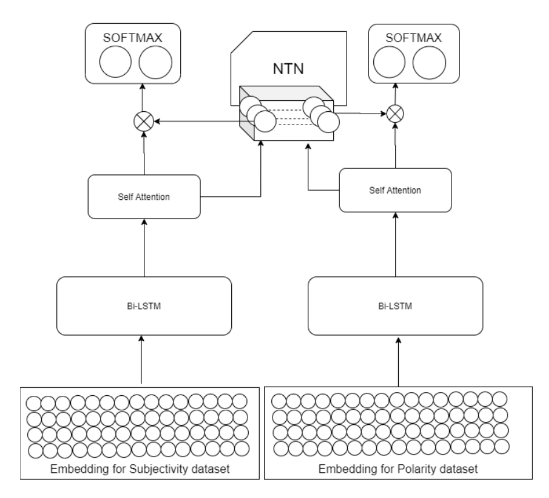</center>

<center>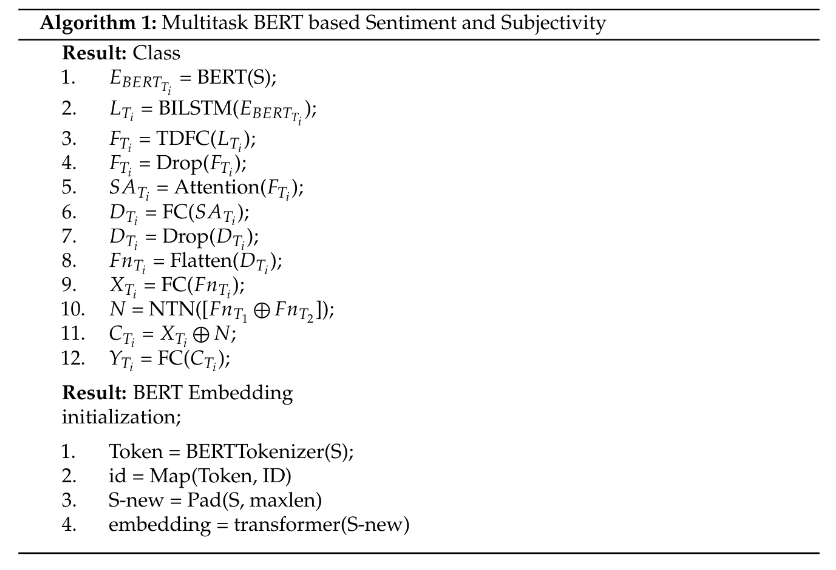</center>

In [102]:
class TimeDistributedLayer(nn.Module):
    def __init__(self, module, batch_first=False):
        super(TimeDistributedLayer, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y

In [139]:
class NeuralTensorNetwork(nn.Module):
    def __init__(self, output_dim: int, input_dim: int, activation: str="tanh", 
                 mean: float=0.0, std: float=1.0, batch_size: int=128):
        
        super(NeuralTensorNetwork, self).__init__()

        # setting input and output dimensions
        self.k = output_dim
        self.d = input_dim # e1,e2

        # setting mean and std for random initialization
        self.mean = mean
        self.std = std

        self.activation = activation

        self.batch_size = batch_size

        # parameters has been used in order to consider W, V, b as model parameters
        # inference -> they'll be optimized

        # normal sampling -> https://pytorch.org/docs/stable/generated/torch.normal.html
        # parameter -> https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#torch.nn.parameter.Parameter
        self.W = nn.Parameter(torch.normal(self.mean, self.std, size=(self.k, 
                                                                      self.d, 
                                                                      self.d)))
        self.V = nn.Parameter(torch.normal(self.mean, self.std, size=(2*self.d, 
                                                                      self.k)))
        self.b = nn.Parameter(torch.zeros(size=(self.d,)))
        
        if activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif self.activation == 'relu':
            self.activation = nn.ReLU()
        # checking for a good activation function
        else:
            raise ValueError('Possible activation choices are tanh, sigmoid or ReLU')

    def forward(self, inputs: List[torch.Tensor]) -> torch.Tensor:
        if type(inputs) is not list or len(inputs) <= 1:
            raise Exception('BilinearTensorLayer must be called on a list of tensors '
                      '(at least 2). Got: ' + str(inputs))

        # getting the entities
        e1 = inputs[0]
        e2 = inputs[1]

        #with torch.no_grad():
        #    e1_clone = torch.clone(e1)
        #    batch_size = e1_clone.size(dim=0) #torch.clone(e1).detach().numpy().shape[0]

        batch_size = self.batch_size
        k = self.k
        d = self.d

        # bilinear tensor + bias
        bil_bias = [torch.sum((e2 * torch.matmul(e1, self.W[0])) + self.b, 
                              axis=1)]
        
        for i in range(1,k):
            bil_bias.append(torch.sum((e2*torch.matmul(e1, self.W[i])) + self.b, 
                                      axis=1))
        
        bil_bias = torch.cat(bil_bias, axis=0)
        bil_bias = torch.reshape(bil_bias, (batch_size, k))

        # Vr * [e1, e2]
        rest = torch.matmul(torch.cat([e1,e2], dim=1), self.V)

        e1_R_e2 = bil_bias + rest

        # applying activation
        f = self.activation(e1_R_e2)

        return f

In [130]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [198]:
class MTL(nn.Module):

    def __init__(self, num_heads: int):
        super(MTL, self).__init__()

        # BiLSTMs
        # https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        self.lstm1 = nn.LSTM(input_size=768, hidden_size=128, batch_first=True, dropout=0.2, 
                             bidirectional=True)
        self.lstm2 = nn.LSTM(input_size=768, hidden_size=128, dropout=0.2, 
                             bidirectional=True)

        # TimeDistributed
        self.dense1 = TimeDistributedLayer(nn.Sequential(
                nn.Linear(in_features=256, out_features=128),
                nn.ReLU())
        )

        self.dense2 = TimeDistributedLayer(nn.Sequential(
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU())
        )

################################################################################
        # dense layers
   #     self.dense1 = nn.Sequential(
   #         nn.Linear(in_features=256, out_features=128),
   #         nn.ReLU(inplace=True)
   #         )
   #     

   #     self.dense2 = nn.Sequential(
   #         nn.Linear(in_features=256, out_features=128),
   #         nn.ReLU(inplace=True)
   #         )
################################################################################ 

        # dropout layers
        self.drop1 = nn.Dropout(p=0.5)
        self.drop2 = nn.Dropout(p=0.5)

        # MultiHeadAttention
        #query Q
        self.pol_dense_q = nn.Sequential(
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU()
        )
        #key K
        self.pol_dense_k = nn.Sequential(
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU()
        )
        #value V
        self.pol_dense_v = nn.Sequential(
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU()
        )

        #query Q
        self.subj_dense_q = nn.Sequential(
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU()
        )
        #key K
        self.subj_dense_k = nn.Sequential(
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU()
        )
        #value V
        self.subj_dense_v = nn.Sequential(
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU()
        )

        # https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html
        self.attention1 = nn.MultiheadAttention(embed_dim=128, 
                                                num_heads=num_heads)
        self.attention2 = nn.MultiheadAttention(embed_dim=128, 
                                                num_heads=num_heads)

        # Dense Layers
        self.dense12 = nn.Sequential(
            nn.Linear(in_features=128, out_features=10),
            nn.ReLU()
        )

        self.dense22 = nn.Sequential(
            nn.Linear(in_features=128, out_features=10),
            nn.ReLU()
        )

        # dropout
        self.drop3 = nn.Dropout(0.5)
        self.drop4 = nn.Dropout(0.5)

        # flattening
        #self.flat1 = nn.Linear(in_features=10, out_features=450)
        #self.flat2 = nn.Linear(in_features=10, out_features=450)

        self.flat1 = nn.Flatten(start_dim=1, end_dim=-1)
        self.flat2 = nn.Flatten(start_dim=1, end_dim=-1)

        # Neural Tensor Layer
        self.ntn = NeuralTensorNetwork(output_dim=64, input_dim=450)

        # Dense
        self.flat11 = nn.Sequential(
            nn.Linear(in_features=450, out_features=50),
            nn.ReLU()
        )
        self.flat22 = nn.Sequential(
            nn.Linear(in_features=450, out_features=50),
            nn.ReLU()
        )

        # final layers (the softmax will be applied at the end by the loss)
        self.pred1 = nn.Linear(in_features=114, out_features=2)
        self.pred2 = nn.Linear(in_features=114, out_features=2)


    def forward(self, emb1, emb2) -> Tuple:

        print(f"Embedding sizes :\nPolarity {emb1.size()}\nSubjectivity {emb2.size()}")
        # https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        pol_out, (h_pol, c_pol) = self.lstm1(emb1)
        pol_hidden = torch.cat((pol_out[:,-1,:128], pol_out[:,0,128:]), dim=1)
        
        subj_out, (h_subj, c_subj) = self.lstm2(emb2)
        subj_hidden = torch.cat((subj_out[:,-1,:128], subj_out[:,0,128:]), 
                                dim=1)

        print(f"Pol LSTM out : {pol_out.size()}\n")
        #pol = self.dense1(pol_hidden.view(-1, 128*2))
        print(f"Pol LSTM out : {subj_out.size()}\n")
        #subj = self.dense2(subj_hidden.view(-1, 128*2))

        #print(f"First Dense Layer : {pol.size()}\n")
        pol = self.dense1(pol_out)
        subj = self.dense2(subj_out)

        drop1 = self.drop1(pol)
        drop2 = self.drop2(subj)

        print(f"First Dropout Layer : {drop1.size()}\n")

        pol_q = self.pol_dense_q(drop1)
        pol_k = self.pol_dense_k(drop1)
        pol_v = self.pol_dense_v(drop1)

        subj_q = self.subj_dense_q(drop2)
        subj_k = self.subj_dense_k(drop2)
        subj_v = self.subj_dense_v(drop2)

        # https://stackoverflow.com/questions/65642832/inputs-to-the-nn-multiheadattention
        attn_out1, _ = self.attention1(query=pol_q, key=pol_k, value=pol_v)
        attn_out2, _ = self.attention2(query=subj_q, key=subj_k, value=subj_v)

        print(f"Firse Attn Layer : {attn_out1.size()}\n")

        pol_dense = self.dense12(attn_out1)
        subj_dense = self.dense22(attn_out2)

        print(f"Second Dense Layer : {pol_dense.size()}\n")

        drop3 = self.drop3(pol_dense)
        drop4 = self.drop4(subj_dense)

        print(f"Second Dropout Layer : {drop3.size()}\n")

        pol_flat = self.flat1(drop3)
        subj_flat = self.flat2(drop4)

        print(f"Flattening  Layer : {pol_flat.size()}\n")

        ntn_output = self.ntn([pol_flat, subj_flat])

        pol_flat1 = self.flat11(pol_flat)
        subj_flat1 = self.flat22(subj_flat)

        pol_merged = torch.concat((pol_flat1, ntn_output), dim=1)
        subj_merged = torch.concat((subj_flat1, ntn_output), dim=1)

        pol_out = self.pred1(pol_merged)
        subj_out = self.pred2(subj_merged)

        return pol_out, subj_out

In [199]:
def cross_entropy_loss() -> torch.nn.CrossEntropyLoss :
    loss = torch.nn.CrossEntropyLoss()
    return loss

In [200]:
def get_optimizer(net, lr: float=0.001):
    return torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    #return opt.SGD(net.parameters(), lr=lr, wd=0.000001, mom=0.9)

In [201]:
def training_step(model, pol_train: torch.utils.data.DataLoader, 
                  sub_train: torch.utils.data.DataLoader, cost_function_pol, 
                  cost_function_subj, optimizer, device: str = ('cuda:0' if torch.cuda.is_available() else 'cpu')) -> Tuple[float]:
    
    samples = 0.

    cumulative_pol_accuracy = 0.
    cumulative_subj_accuracy = 0.

    total_cumulative_loss = 0.
    model.train() 

    subj_train_iter = iter(sub_train)
 
    # iterate over the training set
    for batch_idx, (pol_tensor, pol_label) in enumerate(pol_train):
        # gradients reset
        optimizer.zero_grad()

        # print(pol_tensor.size()) -> torch.Size([64, 64, 768])
        # print(pol_label.size()) -> [64]

        # load polarity data to GPU
        pol_inputs = pol_tensor.to(device)
        pol_labels = pol_label.to(device).to(torch.long)
        #print(f"True label pol : {pol_label}")

        # print(subj_inputs.size()) -> torch.Size([64, 64, 768])
        # print(subj_labels.size()) -> [64]

        # load subjectivity data to GPU
        subj_inputs, subj_labels = next(subj_train_iter)
        subj_inputs = subj_inputs.to(device)
        subj_labels = subj_labels.to(device).to(torch.long)

        #print(f"True label subj : {subj_labels}\n")
        
        # forward pass -> the output should be two vecotors.
        # as a consequence two losses
        pol_out, subj_out = model(pol_inputs, subj_inputs)

        #print(pol_out.size()) -> torch.Size([64,2])
        #print(subj_out.size()) -> torch.Size([64,2])

        # loss computation
        pol_loss = cost_function_pol(pol_out, pol_labels)
        sub_loss = cost_function_subj(subj_out, subj_labels)

        cumulative_loss = pol_loss + sub_loss
        
        # backward pass
        #pol_loss.backward(retain_graph=True)
        #sub_loss.backward()
        cumulative_loss.backward()
    
        # parameters update
        optimizer.step()

        # fetch prediction and loss value for polarity 
        #samples_pol += pol_inputs.shape[0]
        #cumulative_pol_loss += pol_loss.item()
        #_, predicted_pol = pol_out.max(dim=1) # max() returns (maximum_value, index_of_maximum_value)
#
        ## compute training accuracy
        #cumulative_pol_accuracy += predicted_pol.eq(pol_labels).sum().item()
        #
        ## fetch prediction and loss value for subjectivity dataset
        #samples_subj += subj_inputs.shape[0]
        #cumulative_subj_loss += sub_loss.item()
        #_, predicted_sub = subj_out.max(dim=1) # max() returns (maximum_value, index_of_maximum_value)
#
        ## compute training accuracy
        #cumulative_subj_accuracy += predicted_sub.eq(subj_labels).sum().item()

        #fetch prediction and loss value for polarity 
        samples += pol_inputs.shape[0]
        total_cumulative_loss += cumulative_loss.item()
        _, predicted_pol = pol_out.max(dim=1) # max() returns (maximum_value, index_of_maximum_value)
        _, predicted_subj = subj_out.max(dim=1) # max() returns (maximum_value, index_of_maximum_value)

        #print(f"Predicted label : {predicted_pol}")
        #print(f"Predicted subj : {predicted_subj}\n")

        cumulative_pol_accuracy += predicted_pol.eq(pol_labels).sum().item()
        cumulative_subj_accuracy += predicted_subj.eq(subj_labels).sum().item()

    return total_cumulative_loss/samples, (cumulative_pol_accuracy/samples)*100, (cumulative_subj_accuracy/samples)*100    
    #return cumulative_pol_loss/samples_pol,(cumulative_pol_accuracy/samples_pol)*100, cumulative_subj_loss/samples_subj, (cumulative_subj_accuracy/samples_subj)*100    

In [202]:
def test_step(model, pol_test: torch.utils.data.DataLoader, 
              subj_test: torch.utils.data.DataLoader, cost_function_pol, 
              cost_function_subj, device=('cuda:0' if torch.cuda.is_available() else 'cpu'))->Tuple[float]:

    samples = 0.

    cumulative_pol_accuracy = 0.
    cumulative_subj_accuracy = 0.

    total_cumulative_loss = 0.

    model.eval()
    subj_test_iter = iter(subj_test)

    with torch.no_grad():
        
        for batch_idx, (pol_tensor, pol_label) in enumerate(pol_test):

            #print(pol_tensor.size())# -> torch.Size([64, 64, 768])
            #print(pol_label.size())# -> [64]

            # load polarity data to GPU
            pol_inputs = pol_tensor.to(device)
            pol_labels = pol_label.to(device).to(torch.long)

            # print(subj_inputs.size()) -> torch.Size([64, 64, 768])
            # print(subj_labels.size()) -> [64]

            # load subjectivity data to GPU
            subj_inputs, subj_labels = next(subj_test_iter)
            subj_inputs = subj_inputs.to(device)
            subj_labels = subj_labels.to(device).to(torch.long)

            # forward pass -> the output should be two vecotors.
            # as a consequence two losses
            pol_out, subj_out = model(pol_inputs, subj_inputs)

            #print(pol_out.size()) -> torch.Size([64,2])
            #print(subj_out.size()) -> torch.Size([64,2])

            # apply the loss
            pol_loss = cost_function_pol(pol_out, pol_labels)
            sub_loss = cost_function_subj(subj_out, subj_labels)
        
            # fetch prediction and loss value for polarity 
            samples_pol += pol_inputs.shape[0]
            cumulative_pol_loss += pol_loss.item()
            _, predicted_pol = pol_out.max(dim=1) # max() returns (maximum_value, index_of_maximum_value)

            # compute training accuracy
            cumulative_pol_accuracy += predicted_pol.eq(pol_labels).sum().item()
        
            # fetch prediction and loss value for subjectivity dataset
            samples_subj += subj_inputs.shape[0]
            cumulative_subj_loss += sub_loss.item()
            _, predicted_sub = subj_out.max(dim=1) # max() returns (maximum_value, index_of_maximum_value)

            # compute training accuracy
            cumulative_subj_accuracy += predicted_sub.eq(subj_labels).sum().item()

    return cumulative_pol_loss/samples_pol,(cumulative_pol_accuracy/samples_pol)*100, cumulative_subj_loss/samples_subj, (cumulative_subj_accuracy/samples_subj)*100    

In [203]:
# tensorboard logging utilities
def log_values(writer, step, loss, accuracy, prefix):
  writer.add_scalar(f"{prefix}/loss", loss, step)
  writer.add_scalar(f"{prefix}/accuracy", accuracy, step)

In [204]:
def main(#pol_train_loader,
         #pol_test_loader,
         #subj_train_loader,
         #subj_test_loader,
         pol_embs, 
         subj_embs,
         pol_labels,
         subj_labels,
         batch_size=128,
         device=('cuda:0' if torch.cuda.is_available() else 'cpu'),
         epochs=20) -> Tuple[float]:
  
  
    net = MTL(num_heads=16).to(device)
    #print(net)
    print('Network Init Done')
    cost_function_pol=cross_entropy_loss()
    cost_function_subj=cross_entropy_loss()
    print('Got Loss')
    optimizer = get_optimizer(net)
    print("Got Optimizer")

    pol_train_loader, pol_val_loader, subj_train_loader, subj_val_loader = get_data(pol_embs=pol_embs, 
                                                                                    subj_embs=subj_embs,
                                                                                    pol_labels=pol_labels,
                                                                                    subj_labels=subj_labels,
                                                                                    batch_size=batch_size)

    for e in range(epochs):
        print(f"Epoch {e}:")

        #pol_train_loss, pol_train_accuracy, subj_train_loss, subj_train_accuracy = training_step(model=net, pol_train=pol_train_loader, 
        train_loss, pol_train_accuracy, subj_train_accuracy = training_step(model=net, pol_train=pol_train_loader, 
                                                                            sub_train=subj_train_loader, 
                                                                            cost_function_pol=cost_function_pol, 
                                                                            cost_function_subj=cost_function_subj, 
                                                                            optimizer=optimizer)

        print(f"Training loss: {train_loss}\nPol training accuracy: {pol_train_accuracy}\nSub training accuracy: {subj_train_accuracy}")

    # perform final test step and print the final metrics
    pol_test_loss, pol_test_accuracy, subj_test_loss, subj_test_accuracy = test_step(model=net, 
                                                                                    pol_test=pol_val_loader, 
                                                                                    subj_test=subj_val_loader,
                                                                                    cost_function_pol=cost_function_pol, 
                                                                                    cost_function_subj=cost_function_subj)

    return pol_test_loss, pol_test_accuracy, subj_test_loss, subj_test_accuracy

In [205]:
#pol_loss, pol_accuracy, subj_loss, subj_accuracy = main(pol_train_loader=pol_train, pol_test_loader=pol_val, subj_train_loader=subj_train, subj_test_loader=subj_val)
pol_loss, pol_accuracy, subj_loss, subj_accuracy = main(pol_embs=pol_embs, subj_embs=subj_embs, pol_labels=pol_labels, subj_labels=subj_labels)
print(f"Final statistics : Pol loss: {pol_loss} Pol accuracy : {pol_accuracy} Subj loss : {subj_loss} Subj accuracy : {subj_accuracy}")

Network Init Done
Got Loss
Got Optimizer
Epoch 0:
Embedding sizes :
Polarity torch.Size([128, 45, 768])
Subjectivity torch.Size([128, 45, 768])
Pol LSTM out : torch.Size([128, 45, 256])

Pol LSTM out : torch.Size([128, 45, 256])

First Dropout Layer : torch.Size([128, 45, 128])

Firse Attn Layer : torch.Size([128, 45, 128])

Second Dense Layer : torch.Size([128, 45, 10])

Second Dropout Layer : torch.Size([128, 45, 10])

Flattening  Layer : torch.Size([128, 450])

Embedding sizes :
Polarity torch.Size([128, 45, 768])
Subjectivity torch.Size([128, 45, 768])
Pol LSTM out : torch.Size([128, 45, 256])

Pol LSTM out : torch.Size([128, 45, 256])

First Dropout Layer : torch.Size([128, 45, 128])

Firse Attn Layer : torch.Size([128, 45, 128])

Second Dense Layer : torch.Size([128, 45, 10])

Second Dropout Layer : torch.Size([128, 45, 10])

Flattening  Layer : torch.Size([128, 450])

Embedding sizes :
Polarity torch.Size([128, 45, 768])
Subjectivity torch.Size([128, 45, 768])
Pol LSTM out : tor

KeyboardInterrupt: ignored

## Tensorflow

In [ ]:
!pip install keras-self-attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18912 sha256=89c5a25fdc3800d149248a505a62247fbc140f1493ccd4e09a39a1f7e65dab81
  Stored in directory: /root/.cache/pip/wheels/95/b1/a8/5ee00cc137940b2f6fa198212e8f45d813d0e0d9c3a04035a3
Successfully built keras-self-attention


In [88]:
import sys
import keras
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
import io
from keras.utils import pad_sequences
import pandas as pd
import csv
from keras.layers import Input
from keras.layers import Concatenate
import scipy.stats as stats
from keras import backend as K
from keras.layers.core import Lambda
from keras.layers import Layer
from keras.models import Sequential
from keras.layers import Input,Dense,GRU,LSTM,Concatenate,Dropout,Activation,Add, Masking, Concatenate, Dot, RepeatVector, Permute, Multiply, Dense
from keras.layers.pooling import AveragePooling1D,MaxPooling1D
from keras.layers.core import Flatten
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv1D, Conv2D
from keras.models import Model
from keras.layers import TimeDistributed, Bidirectional
from keras.layers.core import Reshape
from keras.backend import shape
from keras.utils import plot_model
from keras.layers import Multiply,Concatenate
from keras.optimizers import RMSprop,Adadelta,Adam
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, Dropout, add, concatenate
from keras.layers import Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import text, sequence
from keras.losses import binary_crossentropy
from keras import backend as K
import keras.layers as L
from keras.layers import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.optimizers import Adam
from keras.optimizers import SGD
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from keras.layers import Layer
import keras.backend as K
from keras.utils import plot_model
from keras_self_attention import SeqSelfAttention

ModuleNotFoundError: ignored

In [ ]:
class NeuralTensorLayer(Layer):

  def __init__(self, output_dim, input_dim=None, **kwargs):
    self.output_dim = output_dim #k
    self.input_dim = input_dim   #d
    if self.input_dim:
      kwargs['input_shape'] = (self.input_dim,)
    super(NeuralTensorLayer, self).__init__(**kwargs)

  def build(self, input_shape):
    mean = 0.0
    std = 1.0
    # W : k*d*d
    k = self.output_dim
    d = self.input_dim
    initial_W_values = stats.truncnorm.rvs(-2 * std, 2 * std, loc=mean, scale=std, size=(k,d,d))
    initial_V_values = stats.truncnorm.rvs(-2 * std, 2 * std, loc=mean, scale=std, size=(2*d,k))
    self.W = K.variable(initial_W_values)
    self.V = K.variable(initial_V_values)
    self.b = K.zeros((self.input_dim,))
    self.trainableweights = [self.W, self.V, self.b]

  def call(self, inputs, mask=None):
    if type(inputs) is not list or len(inputs) <= 1:
      raise Exception('BilinearTensorLayer must be called on a list of tensors '
                      '(at least 2). Got: ' + str(inputs))
    e1 = inputs[0]
    e2 = inputs[1]
    batch_size = K.shape(e1)[0]
    k = self.output_dim

    feed_forward_product = K.dot(K.concatenate([e1,e2], axis=1), self.V)
    bilinear_tensor_products = []
    for i in range(k):
      btp = K.sum((e2 * K.dot(e1, self.W[i])) + self.b, axis=1)
      bilinear_tensor_products.append(btp)
    
    result = K.tanh(K.reshape(K.concatenate(bilinear_tensor_products, axis=0), (batch_size, k)) + feed_forward_product)
    return result

  def compute_output_shape(self, input_shape):
    batch_size = input_shape[0][0]
    return (batch_size, self.output_dim)

In [ ]:
###Multi task Model
deep_inputs_1 = Input(shape=(45,768))
deep_inputs_2 = Input(shape=(45,768))

model_1_LSTM = Bidirectional(LSTM(128,return_sequences=True,dropout=0.2,recurrent_dropout=0.3))(deep_inputs_1 ) #task 1
model_2_LSTM = Bidirectional(LSTM(128,return_sequences=True,dropout=0.2,recurrent_dropout=0.3))(deep_inputs_2) #task 2

model_1_dense= TimeDistributed(Dense(128,activation='relu',trainable=True))(model_1_LSTM)
model_2_dense=TimeDistributed(Dense(128,activation='relu',trainable=True))(model_2_LSTM)

model_1_dense = Dropout(0.5)(model_1_dense)
model_2_dense = Dropout(0.5)(model_2_dense)

attention_layer_1 = SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                       kernel_regularizer=keras.regularizers.l2(1e-4),
                       bias_regularizer=keras.regularizers.l1(1e-4),
                       attention_regularizer_weight=1e-4,
                       attention_activation='sigmoid')(model_1_dense) 
                       
attention_layer_2 = SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                       kernel_regularizer=keras.regularizers.l2(1e-4),
                       bias_regularizer=keras.regularizers.l1(1e-4),
                       attention_regularizer_weight=1e-4,
                       attention_activation='sigmoid')(model_2_dense)


model_12_dense = Dense(10,activation='relu',trainable=True)(attention_layer_1)
model_22_dense = Dense(10,activation='relu',trainable=True)(attention_layer_2)

drop_3 = Dropout(0.5)(model_12_dense)
drop_4 = Dropout(0.5)(model_22_dense)

flat_1 = Flatten()(drop_3)
flat_2 = Flatten()(drop_4)

ntn_output = NeuralTensorLayer(output_dim=64, input_dim=450)([flat_1,flat_2])

flat_11 = Dense(50, activation='relu')(flat_1)
flat_22 = Dense(50, activation='relu')(flat_2)

merged_1 = Concatenate(axis=1)([flat_11, ntn_output])
merged_2=Concatenate(axis=1)([flat_22, ntn_output])

predictions1 = Dense(2, activation='softmax')(merged_1) 
predictions2 = Dense(2, activation='softmax')(merged_2)

model = Model(inputs=[deep_inputs_1, deep_inputs_2], outputs=[predictions1, predictions2])

opt = Adam(learning_rate=0.0002)
# opt =SGD(learning_rate=0.002)
model.compile(loss='sparse_crossentropy', optimizer=opt, metrics=['acc'])

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 45, 768)]    0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 45, 768)]    0           []                               
                                                                                                  
 bidirectional_16 (Bidirectiona  (None, 45, 256)     918528      ['input_17[0][0]']               
 l)                                                                                               
                                                                                                  
 bidirectional_17 (Bidirectiona  (None, 45, 256)     918528      ['input_18[0][0]']         

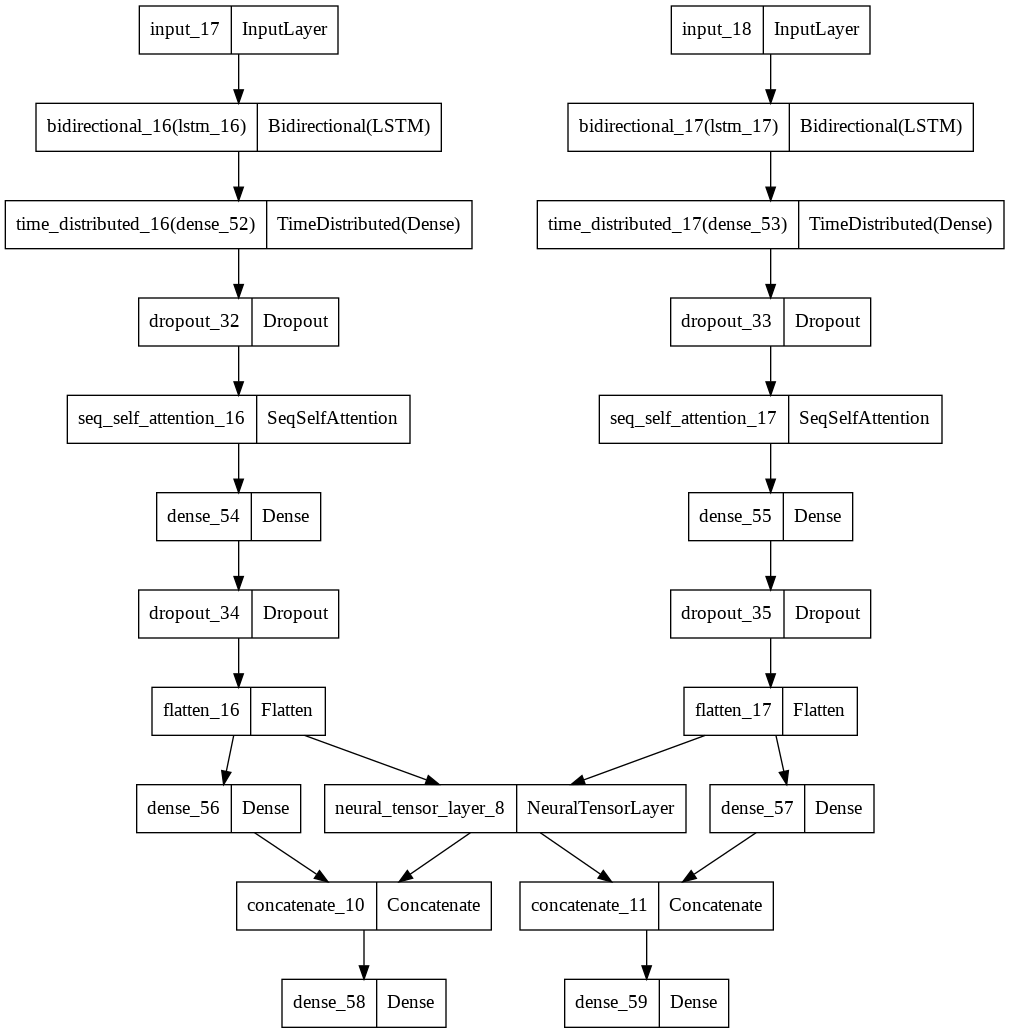

In [ ]:
from keras.utils import plot_model
plot_model(model)

In [ ]:
history=model.fit([pol_embs, subj_embs], [np.array(pol_labels), np.array(subj_labels)], batch_size=128, epochs=20, verbose=1, shuffle=True,validation_split=0.2)

Epoch 1/20
13/13 [==============================] - 76s 4s/step - loss: 1.7660 - dense_58_loss: 0.8574 - dense_59_loss: 0.8743 - dense_58_acc: 0.5269 - dense_59_acc: 0.5231 - val_loss: 2.3784 - val_dense_58_loss: 1.1559 - val_dense_59_loss: 1.1883 - val_dense_58_acc: 0.2275 - val_dense_59_acc: 0.1325
Epoch 2/20
13/13 [==============================] - 51s 4s/step - loss: 1.6277 - dense_58_loss: 0.8076 - dense_59_loss: 0.7860 - dense_58_acc: 0.5512 - dense_59_acc: 0.5969 - val_loss: 2.5434 - val_dense_58_loss: 1.1762 - val_dense_59_loss: 1.3331 - val_dense_58_acc: 0.1925 - val_dense_59_acc: 0.0900
Epoch 3/20
13/13 [==============================] - 50s 4s/step - loss: 1.5676 - dense_58_loss: 0.8269 - dense_59_loss: 0.7067 - dense_58_acc: 0.5681 - dense_59_acc: 0.6438 - val_loss: 2.1669 - val_dense_58_loss: 1.1265 - val_dense_59_loss: 1.0063 - val_dense_58_acc: 0.2175 - val_dense_59_acc: 0.3575
Epoch 4/20
13/13 [==============================] - 51s 4s/step - loss: 1.4857 - dense_58_loss

In [ ]:
score = model.evaluate([pol_embs, subj_embs], [np.array(pol_labels), np.array(subj_labels)], verbose=1)
score

63/63 [==============================] - 18s 287ms/step - loss: 0.2371 - dense_58_loss: 0.1048 - dense_59_loss: 0.0996 - dense_58_acc: 0.9660 - dense_59_acc: 0.9655


[0.23708271980285645,
 0.10478292405605316,
 0.09956906735897064,
 0.9660000205039978,
 0.965499997138977]

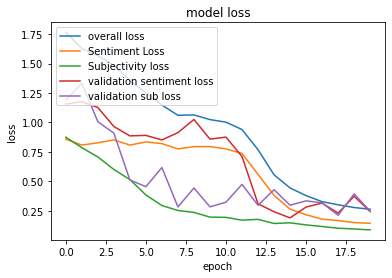

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['dense_58_loss'])
plt.plot(history.history['dense_59_loss'])
plt.plot(history.history['val_dense_58_loss'])
plt.plot(history.history['val_dense_59_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['overall loss','Sentiment Loss', 'Subjectivity loss','validation sentiment loss', 'validation sub loss'], loc='upper left')

plt.show()

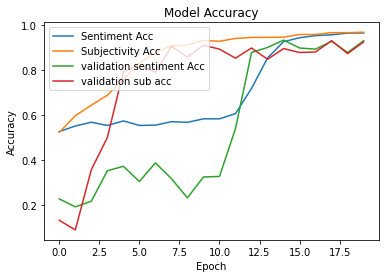

In [ ]:
plt.plot(history.history['dense_58_acc'])
plt.plot(history.history['dense_59_acc'])
plt.plot(history.history['val_dense_58_acc'])
plt.plot(history.history['val_dense_59_acc'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Sentiment Acc', 'Subjectivity Acc','validation sentiment Acc', 'validation sub acc'], loc='upper left')

plt.savefig(root+"Results/Acc_best.png")
#plt.show()

### Unused

In [ ]:
from google.colab import files

files.upload()

{}

In [ ]:
#from ntn_no_print import NeuralTensorNetwork

In [ ]:
#pol_emb = np.load(root + 'pol.npy')
#subj_emb = np.load(root + 'subj_obj.npy')

#pol_embs = np.load(root+'BERT/Polarity-Embeddings/bert_emb_pol_100.npy')
#for i in range(1,20):
#    tmp = np.load(root+f'BERT/Polarity-Embeddings/bert_emb_pol_{(i+1)*100}.npy')
#    print(f"iteration {i}\n")
#    print(f"len tmp {len(tmp)}\n")
#    pol_embs = np.concatenate((pol_embs,tmp))
#    print(f"len pol_embs {len(pol_embs)}\n")

In [ ]:
# first batch. When doing np.save everything is flatten up
# need to rebuild the features to have a list of 2k elements to spit up
print(pol_emb[:64])

In [ ]:
print(pol_emb[0].shape)

In [ ]:
pol_emb_arranged = []

for i in range(0,len(pol_emb)+1, 512):
    if i==0:
        chunk = pol_emb[:512]
    else:    
        chunk = pol_emb[i-512:i]
        pol_emb_arranged.append(chunk)

print(len(pol_emb_arranged))
#print(pol_emb_arranged)

In [ ]:
subj_emb_arranged = []

for i in range(0,len(pol_emb)+1, 512):
    if i==0:
        chunk = subj_emb[:512]
    else:    
        chunk = subj_emb[i-512:i]
        subj_emb_arranged.append(chunk)

print(len(subj_emb_arranged))
#print(pol_emb_arranged)

In [ ]:
import math
import torch.nn.functional as F

In [ ]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [ ]:
# https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html
class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, _ = x.size()
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o